In [1]:
import pprint as pp

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import keras
from keras import layers
from keras.losses import BinaryCrossentropy


2023-09-04 18:30:03.760942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 18:30:03.794257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 18:30:03.795053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 18:30:04.417129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the Titanic dataset.
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.info()

titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [10]:

# attempts to (eventually) preprocess a dataframe of features
# returns all of the collected inputs and preprocessed features 
def process_dataframe_inputs(feature_df):

  # first we walk through each feature in the dataframe, make an input for it,
  # normalize it using the feature_df data, then collect it into lists of
  # inputs and preprocessed inputs, respectively

  input_layers, preprocessed_inputs  = [], []
  for name, col in titanic_features.items():

    # print("processing %s ..." % name)

    cur_dtype = tf.string if col.dtype == object else tf.float64

    cur_input = tf.keras.Input(shape=(1,), name=name, dtype=cur_dtype)
    input_layers.append(cur_input)  

    if cur_dtype == tf.string:
      lookup = layers.StringLookup(vocabulary=np.unique(col))    
      norm = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
      normalized_input = norm(lookup(cur_input))
      preprocessed_inputs.append(normalized_input)

    else:
      norm = layers.Normalization(axis=None)
      norm.adapt(col)
      normalized_input = norm(cur_input)
      preprocessed_inputs.append( normalized_input )

  # prepare the return values by concatentating the preprocessed inputs
  # and creating a model for which they serve as outputs.
  # 
  # returns the input layers and the processed_inputs, respectively

  preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
  titanic_preprocessing_model = tf.keras.Model(input_layers, preprocessed_inputs_cat)
  preprocessed_inputs = titanic_preprocessing_model(input_layers)

  return input_layers, preprocessed_inputs



In [29]:

input_layers, preprocessed_inputs = process_dataframe_inputs(titanic_features)

seqential_hidden_model = tf.keras.Sequential([
  layers.Dropout(0.05),
  layers.Dense(64),
  layers.Dense(16),
  layers.Dense(1)
])
result = seqential_hidden_model(preprocessed_inputs)
titanic_model = tf.keras.Model(input_layers, result)
titanic_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

titanic_features_dict = {
  name: np.array(value) for name, value in titanic_features.items()
}

hist = titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=100, batch_size=10)


Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 2.0256 - accuracy: 0.6683
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3211 - accuracy: 0.7352
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2410 - accuracy: 0.7767
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1081 - accuracy: 0.7767
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9788 - accuracy: 0.6332
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.7480
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5550 - accuracy: 0.7831
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7356 - accuracy: 0.8070
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.7879
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.8006
Epoch 11/

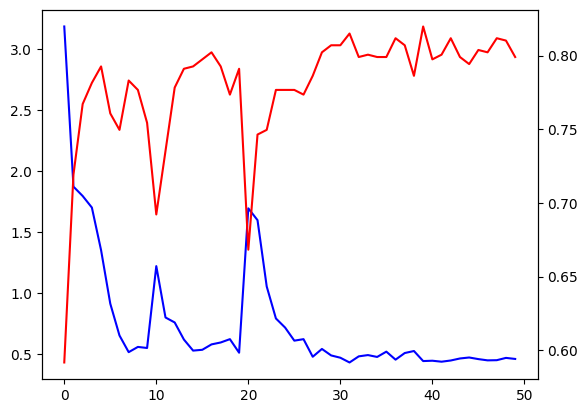

In [24]:

fig, ax1 = plt.subplots()
ax1.plot(hist.epoch, hist.history['loss'], label='loss', color="blue")
ax2 = ax1.twinx()
ax2.plot(hist.epoch, hist.history['accuracy'], label='accuracy', color="red")

plt.show()

